# OncoImaging

## A multi-class CNN based approach for cancer detection on tissue images
Dataset used: https://www.kaggle.com/datasets/obulisainaren/multi-cancer/data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, models
from keras.applications.mobilenet_v3 import preprocess_input
from keras.preprocessing import image_dataset_from_directory, image
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
import math
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input

I decided to ignore the part of the dataset that included all types of cancer due to it not having relevance in my case. Because of that, I needed to write a function that would load the dataset but ignore what I wanted it to ignore.

In [31]:
def load_data_filtered(exclude_types, subset):
    print(f"Loading multi-cancer dataset excluding {exclude_types}")
    full_dir = r"C:\Users\User\ACLabs\OncoImaging\Multi Cancer\Multi Cancer"
    class_dirs = [
        d for d in os.listdir(full_dir)
        if os.path.isdir(os.path.join(full_dir, d)) and d != exclude_types
    ]
    temp_dir = r"C:\Users\User\ACLabs\OncoImaging\filtered_data"

    # Create symlinked structure if it doesn't already exist
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
        for d in class_dirs:
            os.symlink(os.path.join(full_dir, d), os.path.join(temp_dir, d))

    return tf.keras.preprocessing.image_dataset_from_directory(
        temp_dir,
        labels = 'inferred',
        label_mode = 'categorical',
        validation_split = 0.25,
        subset = subset,
        seed = 69,
        batch_size = 32,
        image_size = (224, 224),
        shuffle = True
    )

main_train = load_data_filtered("ALL", "training")
main_validation = load_data_filtered("ALL", "validation")

Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 82502 files for training.
Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 27500 files for validation.


Below is an image of each class, to understand what we're working with:

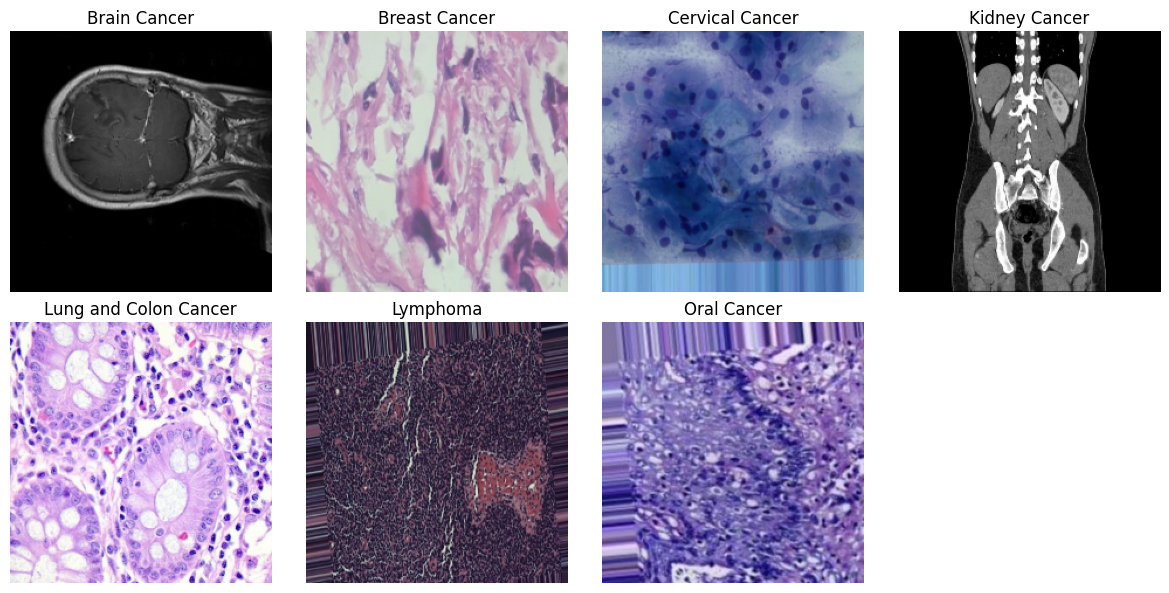

In [4]:
class_names = main_train.class_names

plot_images = {cls: None for cls in class_names}

for batch in main_train.unbatch().batch(1):
    img, label = batch
    index = np.argmax(label.numpy())
    cls = class_names[index]
    if plot_images[cls] is None:
        plot_images[cls] = img[0].numpy().astype("uint8")
    if all(v is not None for v in plot_images.values()):
        break 

length = len(class_names)
cols = 4
rows = math.ceil(length / cols)

plt.figure(figsize=(cols * 3, rows * 3))
for i, cls in enumerate(class_names):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(plot_images[cls])
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

Now we will have two models: the pretrained MobileNetV3Large one, which is based on multiple CNN layers alongside other ones like Droupout layers, Pooling layers and even some simple Dense layers. I forgot to ask for a model summary, but looking it up, we can see that the MobileNet model has around 4,200,000 parameters. And the second model, which is the one that I made.

In [3]:
def create_model(num_classes):
    pre_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze the base model layers to use transfer learning
    pre_model.trainable = False
    
    # Add custom classification layers
    x = pre_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = models.Model(inputs=pre_model.input, outputs=output_layer)
    
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [5]:
def train_model(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes)
    history = model.fit(train_data, validation_data=val_data, epochs=5)  # Store history
    model.save(f"{model_name}_model.h5")
    return history, model  # Return both history and model

In [6]:
num_classes = 7

history, model = train_model(main_train, main_validation, num_classes, "")

loss, accuracy = model.evaluate(main_validation)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/5
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1219s 235ms/step - accuracy: 0.9840 - loss: 0.0574 - val_accuracy: 0.9988 - val_loss: 0.0038
Epoch 2/5
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1181s 229ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0052
Epoch 3/5
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1184s 230ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 8.4507e-04
Epoch 4/5
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1225s 237ms/step - accuracy: 0.9998 - loss: 9.0459e-04 - val_accuracy: 0.9966 - val_loss: 0.0109
Epoch 5/5
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1197s 232ms/step - accuracy: 0.9998 - loss: 9.5385e-04 - val_accuracy: 0.9996 - val_loss: 0.0012


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 289s 168ms/step - accuracy: 0.9994 - loss: 0.0015
Evaluation Results - Loss: 0.0011614796239882708, Accuracy: 0.9995636343955994


As you can see, even with a pre-trained model, it took about 1h15min to train. Not very good signs for what is to come!

In [41]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Model Loss")

    plt.show()

In [42]:
import random

def plot_sample_predictions(model, dataset, class_names):
    images, labels = next(iter(dataset))
    predictions = model.predict(images)

    num_images = images.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(9, num_images)):  # Show up to 9 images, but not more than available
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[np.argmax(labels[i].numpy())]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="green" if pred_label == true_label else "red")
        plt.axis("off")
    plt.show()

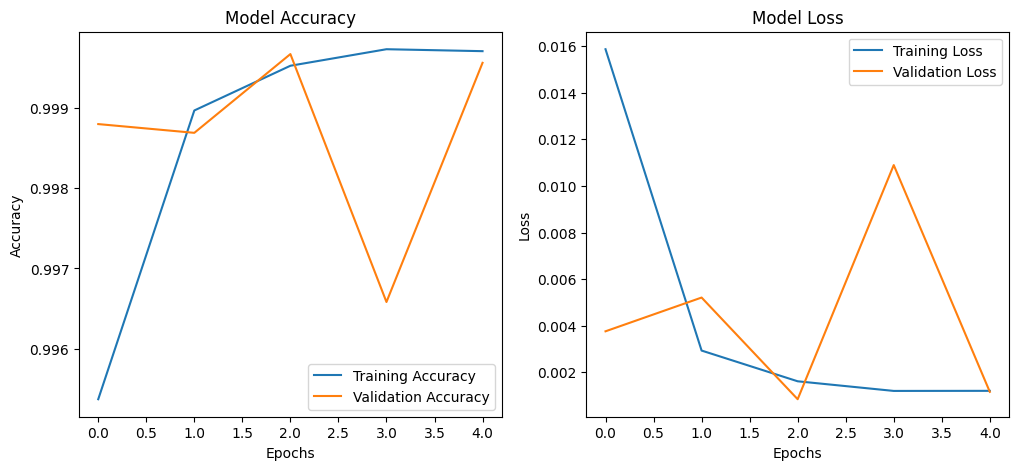

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


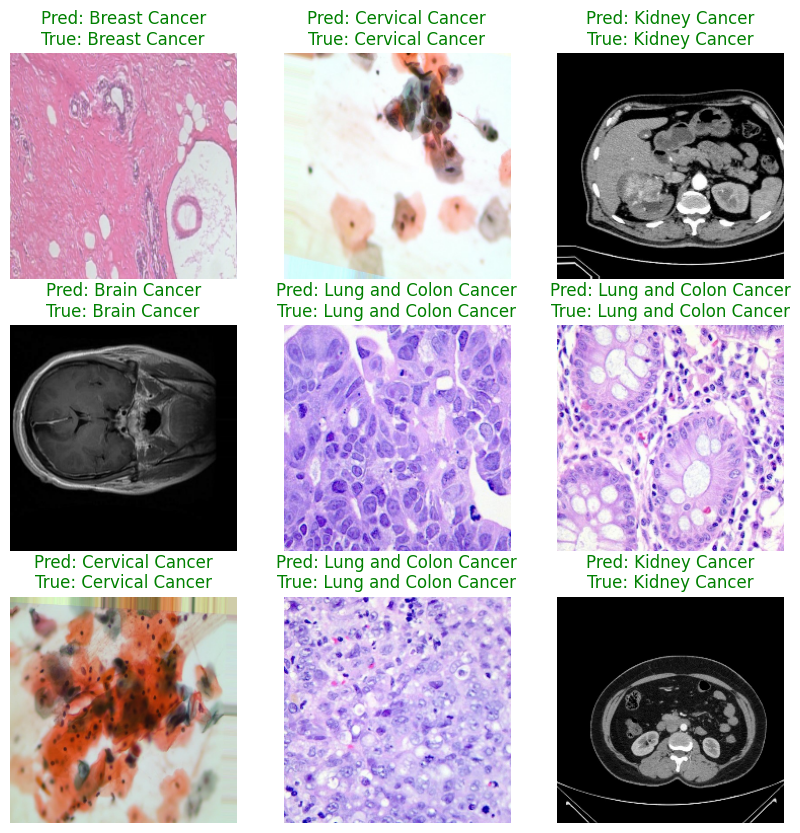

In [9]:
plot_training_history(history)
plot_sample_predictions(model, main_train, main_train.class_names)

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

main_train_normalized = main_train.map(lambda x, y: (normalization_layer(x), y))
main_validation_normalized = main_validation.map(lambda x, y: (normalization_layer(x), y))

And right here is my model, preceded by some normalization of the data. You can see that my model is also pretty big, with around 3,400,000 parameters.

In [33]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(filters = 32,
                 kernel_size = (5, 5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32,
                 kernel_size = (5, 5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,
                 kernel_size = (3, 3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64,
                 kernel_size = (3, 3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))

In [34]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 224, 224, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 112, 112, 64)        │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,471,591 (13.24 MB)

 Trainable params: 3,471,591 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [36]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [37]:
def augment (image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

main_train_augmented = main_train_normalized.map(augment)

In [39]:
train_batches = tf.data.experimental.cardinality(main_train_augmented).numpy()
val_batches = tf.data.experimental.cardinality(main_validation_normalized).numpy()

history = model.fit(
    main_train_augmented,
    epochs=5, 
    validation_data = main_validation_normalized,
    verbose=1, 
    callbacks = callbacks,
    steps_per_epoch=train_batches,
    validation_steps=val_batches
)

Epoch 1/5
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7694 - loss: 0.6364

2579/2579 ━━━━━━━━━━━━━━━━━━━━ 7428s 3s/step - accuracy: 0.7694 - loss: 0.6363 - val_accuracy: 0.9853 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 2/5
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9697 - loss: 0.1049

2579/2579 ━━━━━━━━━━━━━━━━━━━━ 7404s 3s/step - accuracy: 0.9697 - loss: 0.1049 - val_accuracy: 0.9897 - val_loss: 0.0310 - learning_rate: 1.0000e-04
Epoch 3/5
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9832 - loss: 0.0600

2579/2579 ━━━━━━━━━━━━━━━━━━━━ 7405s 3s/step - accuracy: 0.9832 - loss: 0.0600 - val_accuracy: 0.9944 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 4/5
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 7446s 3s/step - accuracy: 0.9881 - loss: 0.0458 - val_accuracy: 0.9943 - val_loss: 0.0180 - learning_rate: 1.0000e-04
Epoch 5/5
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 7351s 3s/step - accuracy: 0.9917 - loss: 0.0302 - val_accuracy: 0.9932 - val_loss: 0.0227 - learning_rate: 1.0000e-04


As I predicted, this would end up taking a reaaaaally long time to train - about 10h. However, we can see that the validation accuracy and loss is comparable to the pre-trained model.

So why did I make two models then? Well for one, I wanted to have a finished project even if it meant that I didn't have a model built on my own, and the second reason would be that after finding out there were pre-trained CNN models, I was really curious on how well they would perform.

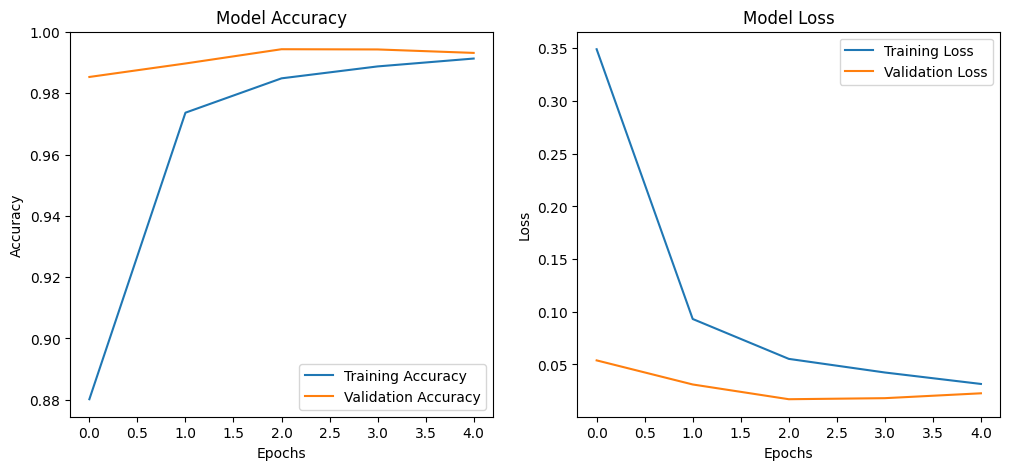

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


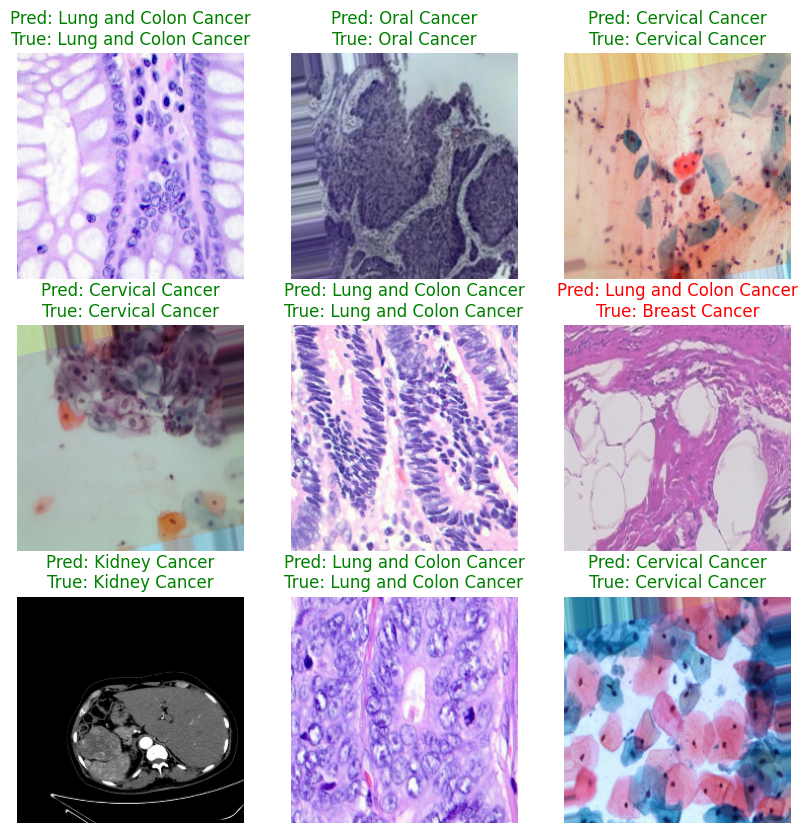

In [53]:
plot_training_history(history)
plot_sample_predictions(model, main_train, main_train.class_names)

A very cool application indeed, showing the power of CNNs - however this is merely a speck of what I had in mind. Initially, I didn't want to use tissue images, because they are very hard to obtain from the human body - expensive, intrusive, and slow. Even if a CNN would be possibly able to detect the cancer faster from these images, it could still benefit from improvements.

My initial idea was to use SERS spectrograms, like the following:<br> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Sers.jpg/500px-Sers.jpg" alt="SERS" width="400"/>

I'm not going to go into too much detail on how they work, it's just that the data is much easier to obtain. You only need bodily fluids and they will have enough information about the state of the whole body. Unfortunately, I've searched a lot and there doesn't seem to be any publicly available labeled datasets for SERS, so for now I had to settle with what was shown above. If I had a little more time, I could've tried to contact the authors of the articles that talked about ML and SERS, but with less than a week available, I couldn't really risk it; however, this will probably be the next thing that I'll work on, so if that sounds interesting to you stay tuned!